In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import nltk
import nltk.corpus
from gensim.models import Word2Vec
import fasttext
import os
from wordcloud import WordCloud
import collections

from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amanshah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/amanshah/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# get words from the text corpus

from nltk.corpus import PlaintextCorpusReader
wordlists = PlaintextCorpusReader('da/processed', '.*')

da_words = []

for file in wordlists.fileids():
        da_words.append(wordlists.words(file))

In [4]:
# get the rosetta data

data_raw = pd.read_excel("rosetta_data_inputs_2023.xls")

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [5]:
# Get main columns and filter rows without headings
data = data_raw[["Overskrift", "Beskrivelse"]]
data = data[data["Overskrift"].notna()]

In [ ]:
# remove danish words, punctuation, and put in lowercase

def filter_danish(text):
       return " ".join(w.lower() for w in nltk.wordpunct_tokenize(text) 
                       if w.casefold() not in da_words and w.isalpha() and w != 'nan')

# combine heading and description
title_strings = data['Overskrift'].astype('str')
description_strings = data['Beskrivelse'].astype('str')
docs = title_strings + " \n\n" + description_strings

docs = docs.apply(filter_danish)

In [103]:
# tokenize text, removing English stopwords

def tokenize_text(text, tokenizer):
    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stop_words]  # Remove stopwords
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

tokens = docs.map(lambda x: tokenize_text(x, nltk.word_tokenize))

In [104]:
# filter non-nouns from the tokens

tags = tokens.map(lambda x: nltk.pos_tag(x))

tag_rejects = ['CC', 'CD', 'DT', 'EX', 'IN', 'LS', 'MD', 'PDT', 'POS', 'PRP', 'PRP$',
               'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 
               'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

# keep foreign words, adjectives, nouns, and interjects
tag_keeps = ['FW', 'JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'UH'] 

def filter_non_nouns(sentence):
        new_sentence = []
        for tuple in sentence:
                if(tuple[1] in tag_keeps):
                        new_sentence.append(tuple)
        return new_sentence

filtered_tags = tags.map(lambda x: filter_non_nouns(x))

def tokens_from_tags(sentence):
        new_sentence = []
        for tuple in sentence:
                new_sentence.append(tuple[0])
        return new_sentence

filtered_tokens = filtered_tags.map(lambda x: tokens_from_tags(x))

In [105]:
# lemmatize the tokens, remove super short or long results

wnl = WordNetLemmatizer()

def lemmatize(sentence):
        new_sentence = []
        for token in sentence:
                lemma = wnl.lemmatize(token)

                # remove super short or super long words
                if (len(lemma) >= 2 and len(lemma) <= 15):
                        new_sentence.append(wnl.lemmatize(lemma))
        return new_sentence

lemmatized_tokens = filtered_tokens.map(lambda x: lemmatize(x))

In [148]:
# generate bigrams, replace as token options

from gensim.models.phrases import Phrases
 
# get tokens as a list
words = []
for sentence in lemmatized_tokens:
        for token in sentence:
                words.append(token)
               
# Bigram using Phraser Model              
bigram_model = Phrases(lemmatized_tokens, min_count = 3, threshold = 10)

bigram_tokens = lemmatized_tokens.map(lambda x: bigram_model[x])

In [ ]:
## Preprocessing for FastText

# create file of tokens

# f = open("lemma_kmeans_tokens.txt", "a")
# for sentence in lemmatized_tokens:
#         for token in sentence:
#                 f.write(token + " ")
#         f.write("\n")
# f.close()

# turn lemmas back into sentences

# def lemma_to_sentence(sentence):
#         new_sentence = ""
#         for token in sentence:
#                 new_sentence = new_sentence + " " + token
#         return new_sentence

# sentence_tokens = lemmatized_tokens.map(lambda x: lemma_to_sentence(x))

## Actual Model

In [150]:
# get token frequencies across the entire dataset

counter = collections.Counter(bigram_tokens.explode().dropna().to_numpy())
freqs = dict(counter)

In [151]:
# setup word2vec embeddings
model = Word2Vec(sentences=bigram_tokens, vector_size=100, workers=1)

In [152]:
# Get FastText Vectors

# fasttext_model = fasttext.train_unsupervised('lemma_kmeans_tokens.txt', "cbow")
# ft_vectors = sentence_tokens.apply(lambda x: fasttext_model.get_sentence_vector(x))

In [153]:
from sklearn import cluster
from sklearn import metrics
NUM_CLUSTERS = 10
X = model.wv.vectors
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
indices = kmeans.fit_predict(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[7 3 7 ... 4 4 4]
Centroids data
[[-1.50650935e-02  2.72203349e-02  1.21195568e-02  7.22166849e-03
   9.85137001e-03 -1.04295760e-01  1.92154385e-02  8.80566984e-02
  -3.05166245e-02 -1.13916639e-02 -3.08055021e-02 -5.14542311e-02
  -1.61132067e-02  3.66246253e-02  3.14504839e-02 -3.96311432e-02
  -3.43881315e-03 -6.62583858e-02  1.87920418e-03 -6.32251874e-02
   4.26391289e-02  1.02021117e-02  1.67888086e-02 -3.51556428e-02
  -9.82004032e-03 -2.55142190e-02 -4.05930169e-02 -5.86841106e-02
  -4.41194512e-02  1.48599558e-02  5.85860051e-02  1.73680671e-02
   2.67533399e-02 -3.80339324e-02 -7.74516840e-04  6.53350726e-02
  -1.64527670e-02 -5.00926264e-02 -2.60869786e-02 -8.73944536e-02
   6.94140466e-03 -6.51283413e-02 -3.81480642e-02 -1.43038072e-02
   3.88283953e-02 -1.09198494e-02 -5.38172610e-02 -4.03591841e-02
   2.04832926e-02  4.12477441e-02  3.95218842e-02 -3.22524533e-02
  -2.96852272e-02 -1.44589664e-02 -3.30133960e-02  3.39077786e-02
   5.33

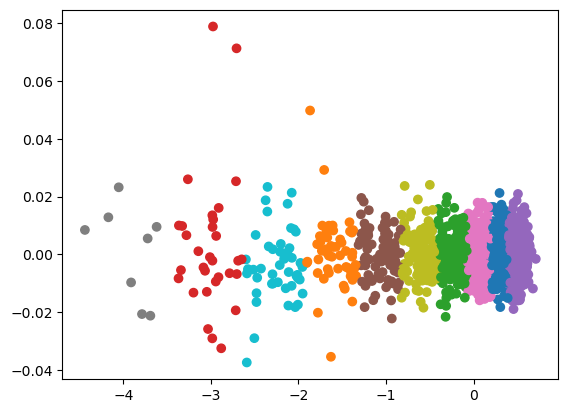

In [154]:
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from matplotlib import pyplot

X = model.wv.vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)

colors = list(mcolors.TABLEAU_COLORS.keys())
pyplot.scatter(result[:, 0], result[:, 1], c = [colors[d] for d in indices])
pyplot.show()

#### Create Word Clouds of K-Means Clusters

In [155]:
# get data subsets for each cluster

cluster_zero_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 0]
cluster_one_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 1]
cluster_two_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 2]
cluster_three_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 3]
cluster_four_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 4]
cluster_five_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 5]
cluster_six_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 6]
cluster_seven_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 7]
cluster_eight_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 8]
cluster_nine_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 9]

word_clusters = [cluster_zero_words, cluster_one_words, cluster_two_words, cluster_three_words, cluster_four_words,
                 cluster_five_words, cluster_six_words, cluster_seven_words, cluster_eight_words, cluster_nine_words]
freq_clusters=[]

for cluster in word_clusters:
        freq_clusters.append({x:freqs[x] for x in cluster})

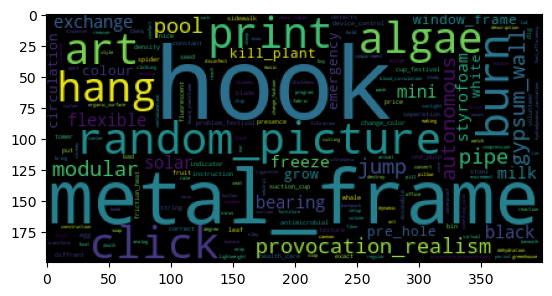

In [156]:
# get frequencies of each cluster's words and create word_clouds

wc = WordCloud().fit_words(freq_clusters[0])
plt.imshow(wc)

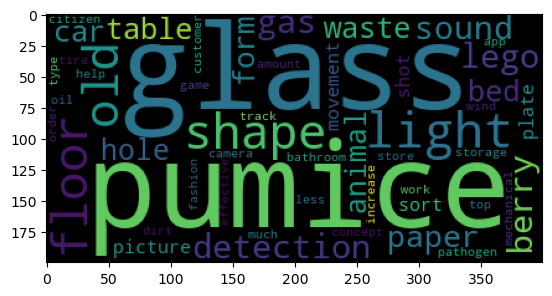

In [157]:
wc = WordCloud().fit_words(freq_clusters[1])
plt.imshow(wc)

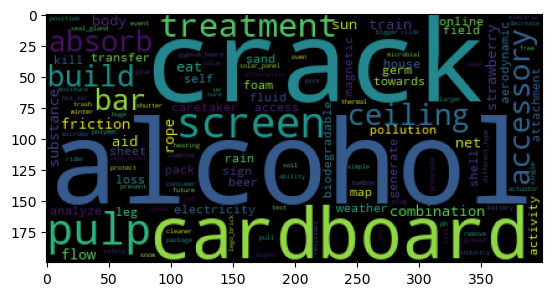

In [158]:
wc = WordCloud().fit_words(freq_clusters[2])
plt.imshow(wc)

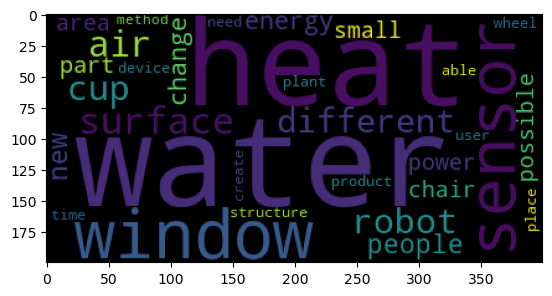

In [159]:
wc = WordCloud().fit_words(freq_clusters[3])
plt.imshow(wc)

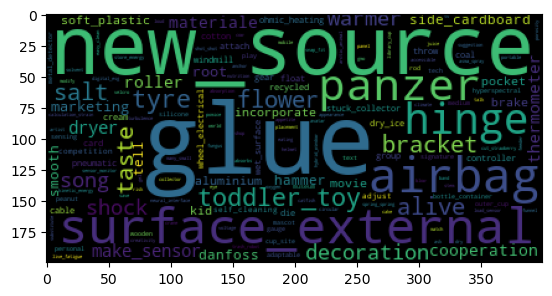

In [160]:
wc = WordCloud().fit_words(freq_clusters[4])
plt.imshow(wc)

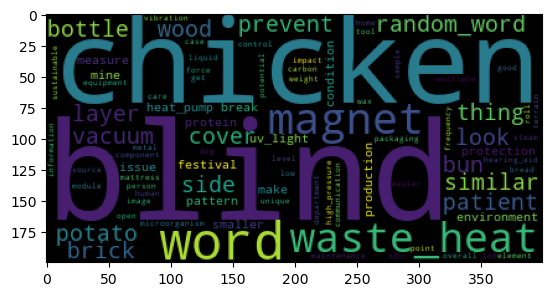

In [161]:
wc = WordCloud().fit_words(freq_clusters[5])
plt.imshow(wc)

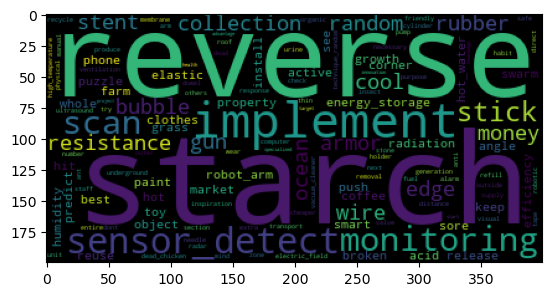

In [162]:
wc = WordCloud().fit_words(freq_clusters[6])
plt.imshow(wc)

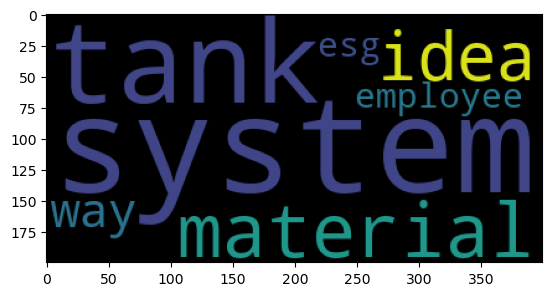

In [163]:
wc = WordCloud().fit_words(freq_clusters[7])
plt.imshow(wc)

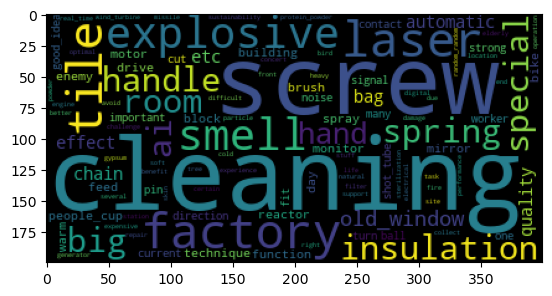

In [164]:
wc = WordCloud().fit_words(freq_clusters[8])
plt.imshow(wc)

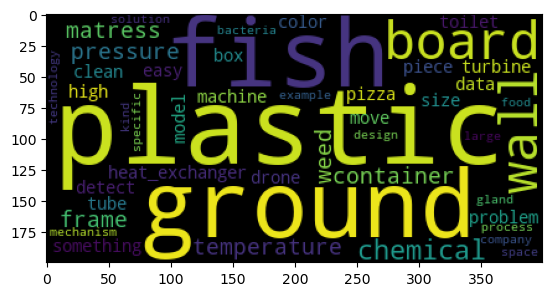

In [165]:
wc = WordCloud().fit_words(freq_clusters[9])
plt.imshow(wc)